===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: Tesla T4
Number of GPUs: 1
GPU Name: Tesla T4
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.14MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

TRAIN SET LENGTH: 60000
TEST SET LENGTH: 10000


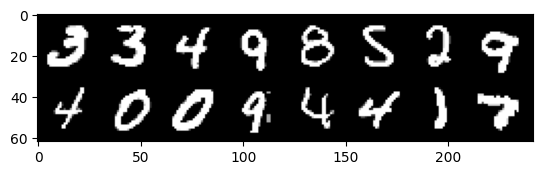

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298679
Train Epoch: 0 [400/60000 (1%)]	Loss: 2.297248
Train Epoch: 0 [800/60000 (1%)]	Loss: 2.288051
Train Epoch: 0 [1200/60000 (2%)]	Loss: 2.285641
Train Epoch: 0 [1600/60000 (3%)]	Loss: 2.078937
Train Epoch: 0 [2000/60000 (3%)]	Loss: 1.997338
Train Epoch: 0 [2400/60000 (4%)]	Loss: 1.923353
Train Epoch: 0 [2800/60000 (5%)]	Loss: 1.421607
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.374767
Train Epoch: 0 [3600/60000 (6%)]	Loss: 1.499787
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.818942
Train Epoch: 0 [4400/60000 (7%)]	Loss: 0.714031
Train Epoch: 0 [4800/60000 (8%)]	Loss: 0.569233
Train Epoch: 0 [5200/60000 (9%)]	Loss: 0.679172
Train Epoch: 0 [5600/60000 (9%)]	Loss: 0.899922
Train Epoch: 0 [6000/60000 (10%)]	Loss: 1.296022
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.245166
Train Epoch: 0 [6800/60000 (11%)]	Loss: 0.521754
Train Epoch: 0 [7200/60000 (12%)]	Loss: 0.520250
Train Epoch: 0 [7600/60000 (13%)]	Loss: 0.436735
Train Epoch: 0 [8000/60000 (13%)]	Loss: 

KeyboardInterrupt: 

In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')

# Define hyperparameters
batch_size = 16
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 100

# Classes for MNIST digits
classes = (0,1,2,3,4,5,6,7,8,9)

# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        # Flatten layer to convert 28x28 images into 784-dim vector
        self.flat = nn.Flatten()

        # Define linear layers
        self.input_layer = nn.Linear(784, 1000)
        self.hidden_layer1 = nn.Linear(1000, 1000)
        self.hidden_layer2 = nn.Linear(1000, 1000)
        self.hidden_layer3 = nn.Linear(1000, 1000)
        self.hidden_layer4 = nn.Linear(1000, 1000)
        self.out = nn.Linear(1000, 10)

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.2)
        self.dropout_layer2 = nn.Dropout(p=0.3)
        self.dropout_layer3 = nn.Dropout(p=0.4)
        self.dropout_layer4 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Flatten the image into a 784-dim vector
        x = x.reshape(-1, 784)

        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))
        x = self.dropout_layer1(F.relu(self.hidden_layer1(x)))
        x = self.dropout_layer2(F.relu(self.hidden_layer2(x)))
        x = self.dropout_layer3(F.relu(self.hidden_layer3(x)))
        x = self.dropout_layer4(F.relu(self.hidden_layer4(x)))

        # IMPORTANT FIX: Do not apply softmax here.
        # CrossEntropyLoss expects raw logits.
        x = self.out(x)

        return x  # Return raw logits

# Instantiate and move model to the selected device
mlp = MLP().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_trainset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transformations
)

trainloader = DataLoader(
    mnist_trainset,
    batch_size=batch_size,
    shuffle=True
)


mnist_testset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transformations
)


testloader = DataLoader(
    mnist_testset,
    batch_size=batch_size,
    shuffle=False,
)

print('TRAIN SET LENGTH:', len(mnist_trainset))
print('TEST SET LENGTH:', len(mnist_testset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

def train(epoch):

    mlp.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()

        output = mlp(data)


        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


def test():
    mlp.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data)

            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()

            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss over the entire test set
    test_loss /= len(testloader)

    # Print test performance
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()
